## Predicting Customer Churn Using an Open-Source Telecom Dataset

Project Structure and Contents

* [Problem Statement](#1-problem-statement)
* [Dataset Information](#2-dataset-information)
* [Objectives](#3-objectives)
* [Import Libraries](#4-import-libraries)
* [Dataset Analysis](#5-dataset-analysis)
    * [Statistical Analysis of the Dataset](#5.1-statistical-analysis-of-the-dataset)
    * [Checking for Missing Values](#5.2-checking-for-missing-values)
* [Exploratory Data Analysis](#6-exploratory-data-analysis-eda)
    * [Geographic Analysis of Churn](#61-geographic-analysis-of-churn)
    * [Demographic Analysis of Churn](#62-demographic-analysis)
    * [Services Analysis of Churn](#63-service-utilization-analysis)
    * [Account Information Analysis of Churn](#64-bill-information-analysis)
* [Data preprocessing for Model](#7-data-preprocessing-for-model) 
    * [Delete column that have no impact on the model](#71-delete-the-columns-that-are-not-required-for-the-model)
    * [Convert categorical features to numerical features](#72-convert-categorial-values-to-numerical-values)
    * [Split the dataset into train and test set](#73-dataset-separation-using-train-test-split) 
* [Model Development and Evaluation](#8-model-development-and-evaluation)
    * [Logistic Regression](#81-model-development-and-evaluation-logistic-regression)
    * [Decision Tree Classifier](#82-model-development-and-evaluation-decision-tree-classifier)
    * [Random Forest Classifier](#83-model-development-and-evaluation-random-forest-classifier)
    * [XGBoost Classifier](#84-model-development-and-evaluation-xgboost-classifier)

* [Conclusion](#9-conclusion)

## 1. Problem Statement
In many service-oriented industries, retaining customers is as crucial as acquiring new 
ones. Customer churn, which refers to customers ceasing their relationship with a company, is a 
significant metric that companies track to understand their service performance.

## 2. Dataset Information
The dataset used in this project is the Telco Customer Churn dataset from Kaggle. It provided home phone and Internet services to 7043 customers in California in Q3. The dataset includes information about customers’ demographics, account information, and services used. The dataset can be downloaded from [here](https://www.kaggle.com/blastchar/telco-customer-churn).




## 3. Objective
- Data Exploration and Cleaning
- Feature Engineering and Selection
- Model Building and Validation
- Model Evaluation
- Deployment

## 4. Import Libraries

In [2]:
import os
import pickle
import folium
import imblearn
import numpy as np 
import pandas as pd 
import seaborn as sns 
import plotly.express as px
import branca.colormap as cm
import matplotlib.pyplot as plt
from collections import Counter

from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score,recall_score, precision_score
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve, auc

## 5. Dataset Analysis
- 5.1 Statistical Analysis of the Dataset
- 5.2 Checking for Missing Values

### 5.1 Statistical Analysis of the Dataset

In [3]:
dataset_path='data/Telco_customer_churn.xlsx'
df = pd.read_excel(dataset_path)
df.head(5)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [4]:
# describe the dataset with basic statistics
df.describe().style.background_gradient(cmap='Blues')

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.000000,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.000000,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.000000,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.000000,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.000000,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.000000,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.000000,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


In [5]:
# dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [6]:
def report_data_types_uniques_check(df):
    col = []
    d_type = []
    uniques = []
    n_uniques = []
    
    for i in df.columns:
        col.append(i)
        d_type.append(df[i].dtypes)
        uniques.append(df[i].unique()[:5])
        n_uniques.append(df[i].nunique())
    
    return pd.DataFrame({'Column': col, 'd_type': d_type, 'unique_sample': uniques, 'n_uniques': n_uniques})

In [7]:
report_data_types_uniques_check(df)

,Column,d_type,unique_sample,n_uniques
0,CustomerID,object,"[3668-QPYBK, 9237-HQITU, 9305-CDSKC, 7892-POOK...",7043
1,Count,int64,[1],1
2,Country,object,[United States],1
3,State,object,[California],1
4,City,object,"[Los Angeles, Beverly Hills, Huntington Park, ...",1129
5,Zip Code,int64,"[90003, 90005, 90006, 90010, 90015]",1652
6,Lat Long,object,"[33.964131, -118.272783, 34.059281, -118.30742...",1652
7,Latitude,float64,"[33.964131, 34.059281, 34.048013, 34.062125, 3...",1652
8,Longitude,float64,"[-118.272783, -118.30742, -118.293953, -118.31...",1651
9,Gender,object,"[Male, Female]",2


Most important features of the dataset are:
- payment method
- gender
- location
- monthly charges
- total charges
- reason to churn 
- online security 
- tech support
- internet service


### 5.2 Checking for Missing Values

In [8]:
df.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

Text(0.5, 1.0, 'Missing null values')

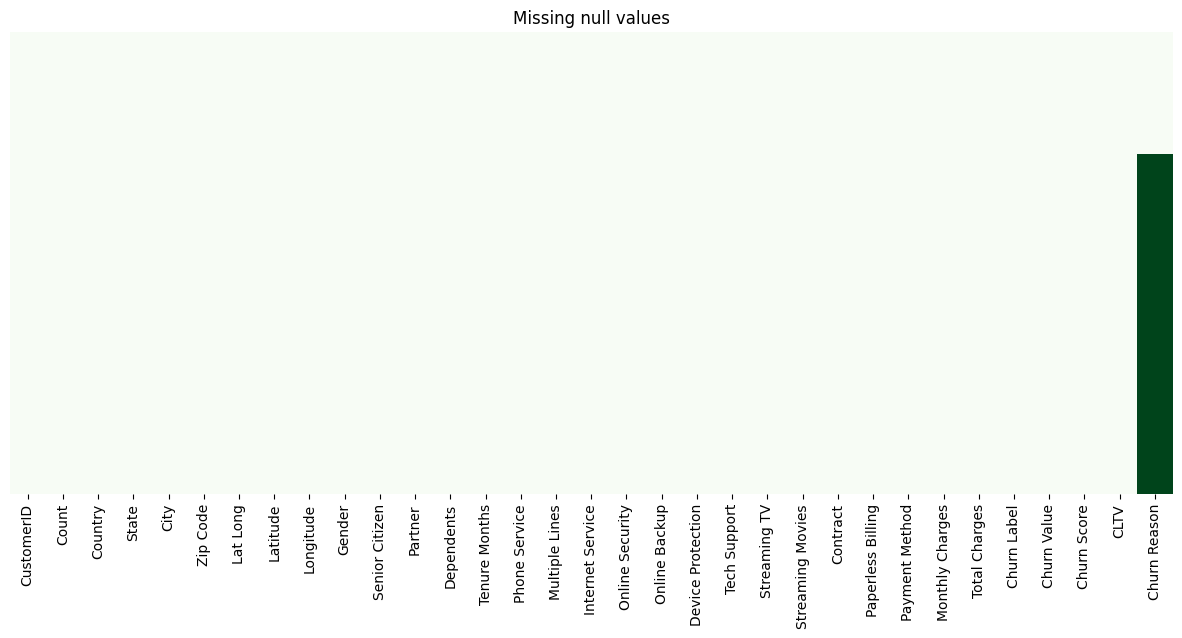

In [9]:
plt.rcParams['figure.figsize'] = (15,6)
sns.heatmap(df.isnull(),yticklabels = False, cbar = False , cmap = 'Greens')
plt.title("Missing null values")

The dataset contains missing values only the **Chrun Reason**. Lets investigate the **Churn Reason** column.

In [10]:
fig = px.bar(df.groupby(['Churn Reason'])['CustomerID'].count().reset_index().sort_values('CustomerID',
                                                                                    ascending=False),
             x='Churn Reason',
             y='CustomerID', 
             color = 'CustomerID',
             text = 'CustomerID')
fig.show()

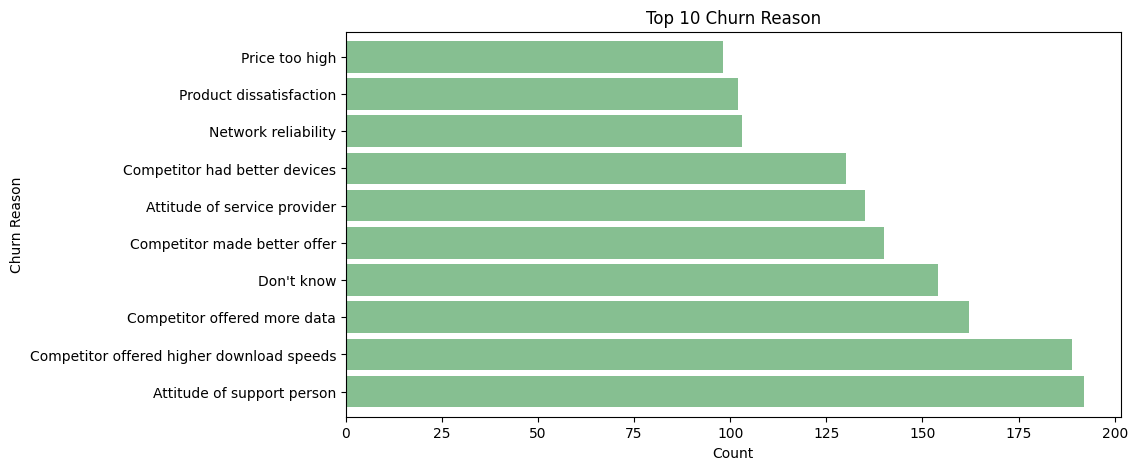

In [11]:
# top 10 reson for churn
df['Churn Reason'].value_counts().head(10).plot(kind='barh', figsize=(10,5), color='#86bf91', zorder=2, width=0.85)
plt.xlabel("Count")
plt.ylabel("Churn Reason")
plt.title("Top 10 Churn Reason")
plt.show()

The 3 most reseon for churn are:
- Attitude of support person
- Competitor offered higher download speeds
- Competitor made better offer

The telco company need to focus to solve this issues to reduce the churn rate.



For handling the missing value, there only **Churn Reason** contains the missing. This values is not give impact on model performance. So, we can drop this column.

## 6. Exploratory Data Analysis (EDA) 
The aim of this project is to predict the customer churn. So, we need to understand the data and find the relationship between the features and target variable.

- 6.1 - Geographic Analysis of Churn
- 6.2 - Demographic Analysis of Churn
- 6.3 - Services Analysis of Churn
- 6.4 - Account Information Analysis of Churn

### Analysis of Churn Rate

In [12]:
fig = px.pie(df.groupby('Churn Label')['CustomerID'].nunique().reset_index(), 
             values='CustomerID', 
             names='Churn Label')
fig.show()

Among the customers in the dataset, **26.5%**  of customers are in churn and have stopped using the company's services. **73.5%** of the customers are retain the service. 

### 6.1 Geographic Analysis of Churn
The dataset contains the geopraphics information about the customer. so investigate the geographic information of the churn and non-churn customers.

In [13]:
df.groupby(['Country','State'])['CustomerID'].count()

Country        State     
United States  California    7043
Name: CustomerID, dtype: int64

All the customers are from California, United States. 

In [14]:
# check the number of cities in the dataset
df['City'].nunique()

1129

In [15]:
fig = px.bar(df.groupby(['City'])['CustomerID'].count().reset_index().sort_values('CustomerID',
                                                                                    ascending=False).head(50),
             x='City',
             y='CustomerID', 
             color = 'CustomerID',
             text = 'CustomerID')
fig.show()

Check the top 10 cities for higher churn rates

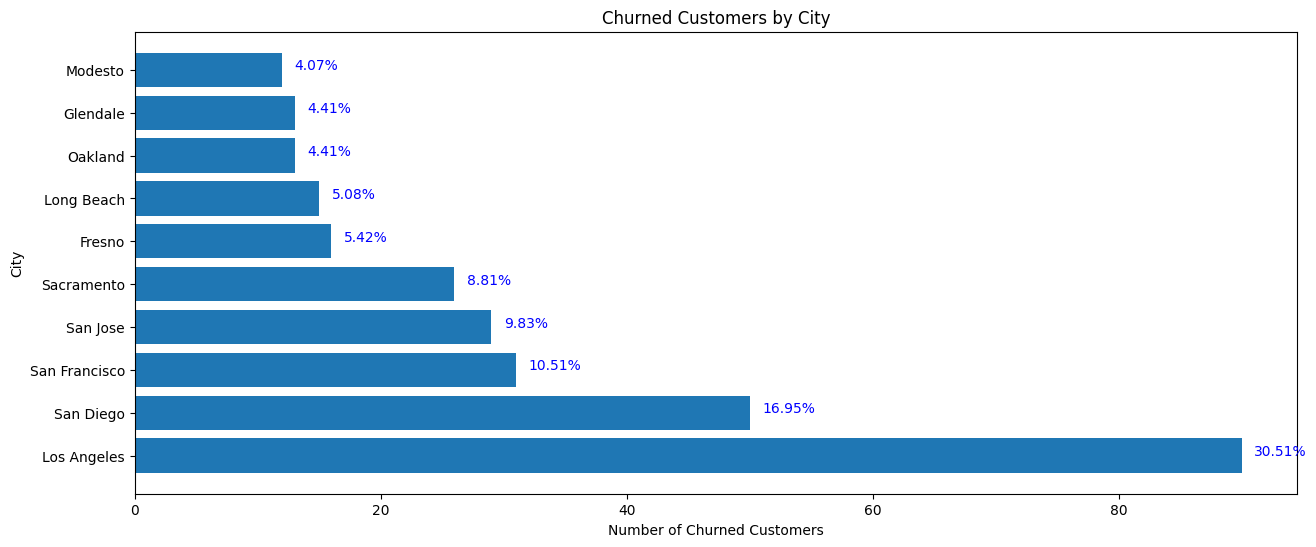

In [16]:

churn_yes_cities = df.loc[df['Churn Label'] == 'Yes', 'City']
city_counts = churn_yes_cities.value_counts().nlargest(10)
city_percentages = (city_counts / city_counts.sum()) * 100
city_counts = pd.concat([city_counts, city_percentages], axis=1)
city_counts.columns = ['Number of Churned Customers', 'Percentage of Churned Customers']
plt.barh(city_counts.index, city_counts.iloc[:, 0])
for i, v in enumerate(city_counts.iloc[:, 1]):
    plt.text(city_counts.iloc[i, 0] + 1, i, f'{v:.2f}%', color='blue')

plt.title('Churned Customers by City')
plt.xlabel('Number of Churned Customers')
plt.ylabel('City')

# Display the plot
plt.show()

Top 3 cities with higher churn rate are:
- Los Angeles
- San Diego
- San Francisco 

The telco company need to focus on these cities to reduce the churn rate.

In the Los Angeles city, the churn rate is the highest. Lets investigate the churn rate in Los Angeles city with the zip code

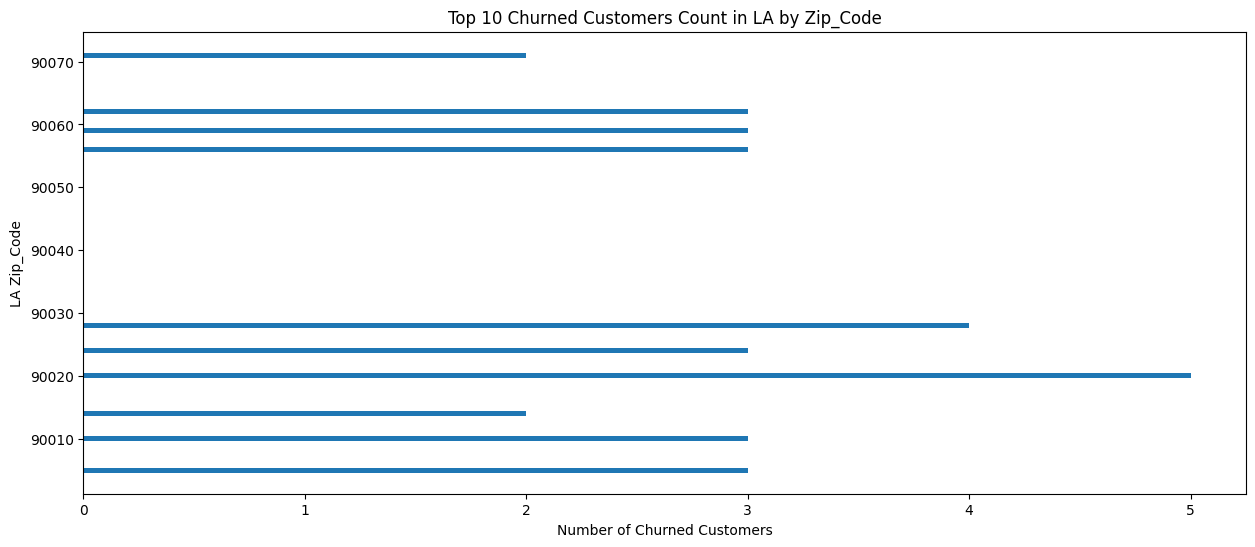

In [17]:

churn_yes_states = df.loc[(df['Churn Label'] == 'Yes') & (df['City'] == 'Los Angeles'), 'Zip Code']

LAZipCnt = churn_yes_states.value_counts().nlargest(10)

plt.barh(LAZipCnt.index, LAZipCnt.values)
plt.title('Top 10 Churned Customers Count in LA by Zip_Code')
plt.xlabel('Number of Churned Customers')
plt.ylabel('LA Zip_Code')
plt.show()

Zip code 90020 has the highest churn rate in Los Angeles city.

### Visualize the location of the churn and non-churn customers in the map.

In [18]:
fig = px.scatter_mapbox(df.groupby(['Latitude','Longitude'])['CustomerID'].count().reset_index(), lat="Latitude", lon="Longitude", hover_data= ['CustomerID'], zoom=4, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In this map, the the largest chrun rate in Los Angles and San Diego city. 

### 6.2 Demographic Analysis
Demographics information such as gender, age , family information have an impact on chrun rate. So investigate the data to find the relationship between the demographic information and churn rate.

- 6.2.1 - Customer Gender
- 6.2.2 - Senior Citizen 
- 6.2.3 - Partner
- 6.2.4 - Dependents
- 6.2.5 - All Demographic Features

#### 6.2.1 Demographic Analysis: Customer Gender

In [19]:

fig = px.pie(df.groupby('Gender')['CustomerID'].count().reset_index(), 
            values='CustomerID', 
            names='Gender',
            title = 'Distribution of the clients by gender')

fig.show()

In [20]:
fig = px.bar(df.groupby(['Gender','Churn Label'])['CustomerID'].count().reset_index(),
             x="CustomerID",
             y="Gender", 
             color="Churn Label", 
             text = 'CustomerID'
            )
fig.show()

There is almost the similar for both men and women for the churn rate. The churn rate for male is 50.5% and the churn rate for female is 49.5% respectively.


#### 6.2.2 Demographic Analysis: Senior Citizen 

In [21]:
fig = px.pie(df.groupby(['Senior Citizen','Churn Label'])['CustomerID'].count().reset_index(), 
            values='CustomerID', 
            names='Churn Label',
            facet_col = 'Senior Citizen',
            color = 'Churn Label',
            title = 'Churn rate by customer age')

fig.show()
            

Chrun rate for the senior citizen is **41.7%** and the churn rate for the non-senior citizen is **23.6%**. The senior citizen have higher churn rate than the non-senior citizen.

In [22]:
df.groupby('Senior Citizen')['CustomerID'].count()

Senior Citizen
No     5901
Yes    1142
Name: CustomerID, dtype: int64

#### 6.2.3 Demographic Analysis: Partner

In [23]:
fig = px.pie(df.groupby('Partner')['CustomerID'].count().reset_index(), 
            values='CustomerID', 
            names='Partner',
            title = 'Distribution of the clients by Partner')
fig.show()

In [24]:
fig = px.pie(df.groupby(['Partner','Churn Label'])['CustomerID'].count().reset_index(), 
            values='CustomerID', 
            names='Churn Label',
            facet_col = 'Partner',
            color = 'Churn Label',
            title = 'Churn rate by Partner')

fig.show()
            

If the customer have a partner, the churn rate is **19.7%** and the churn rate for the customer without partner is **33%**. The customer with partner have lower churn rate than the customer without partner.

#### 6.2.4 Demographic Analysis: Dependents

In [25]:
fig = px.pie(df.groupby('Dependents')['CustomerID'].count().reset_index(), 
            values='CustomerID', 
            names='Dependents',
            title = 'Distribution of the clients by Dependents')
fig.show()

In [26]:
fig = px.pie(df.groupby(['Dependents','Churn Label'])['CustomerID'].count().reset_index(), 
            values='CustomerID', 
            names='Churn Label',
            facet_col = 'Dependents',
            color = 'Churn Label',
            title = 'Churn rate by Dependents')

fig.show()
            

If the customer have dependents, the churn rate is **6.52%** and the churn rate for the customer without dependents is **32.6%**. The customer with dependents have lower churn rate than the customer without dependents.

#### 6.2.5 Demographic Analysis: All Demographic Features

In [27]:
fig = px.bar(df.groupby(['Senior Citizen','Partner',
                                        'Dependents','Churn Label'])['CustomerID'].count().reset_index(),
             x="Senior Citizen",
             y="CustomerID", 
             color="Churn Label", 
             barmode="group",
             facet_row="Partner",
             facet_col = 'Dependents'
            )
fig.show()

The customer with all the demographic features have lower churn rate than the customer without all the demographic features. 

The telco company have to make a business plan about this demographic features to reduce the churn rate.

### 6.3 Service Utilization Analysis 
Analyze service utilization list for the churn and non-churn customers.
- 6.3.1 - Phone Service
- 6.3.2 - Multiple Lines
- 6.3.3 - Internet Service
- 6.3.4 - Streaming TV
- 6.3.5 - Streaming 
- 6.3.6 - Internet Services and Tech Support
- 6.3.7 - Tech support and Online Security
- 6.3.8 - Payment Methods


Let's investigate how the service utilization impact on the churn rate.


#### 6.3.1 Service Utilization Analysis: Phone Service

In [28]:
fig = px.pie(df.groupby(['Phone Service','Churn Label'])['CustomerID'].count().reset_index(), 
            values='CustomerID', 
            names='Churn Label',
            facet_col = 'Phone Service',
            color = 'Churn Label',
            title = 'Churn rate by Phone Service')

fig.show()
            

Phone services have similar impact on the churn rate. The churn rate for the customer with phone service is **26.7%** and the churn rate for the customer without phone service is **24.9%**.

#### 6.3.2 Service Utilization Analysis: Multiple Lines

In [29]:
fig = px.bar(df.groupby('Multiple Lines')['CustomerID'].count().reset_index(),
             x='Multiple Lines',
             y='CustomerID', 
             color = 'Multiple Lines',
             text = 'CustomerID')
fig.show()

In [30]:
fig = px.pie(df.groupby(['Multiple Lines','Churn Label'])['CustomerID'].count().reset_index(), 
             values='CustomerID', 
             facet_col = 'Churn Label',
             names='Multiple Lines',
            title = 'Effect on multiple lines on churn rate')
fig.show()

The customer with multiple lines have lower churn rate than the customer without multiple lines. The churn rate for the customer with multiple lines is **41%** and the churn rate for the customer without multiple lines is **45.4%**.

#### 6.3.3 Service Utilization Analysis: Internet Service

In [31]:
fig = px.pie(df.groupby('Internet Service')['CustomerID'].count().reset_index(), 
            values='CustomerID', 
            names='Internet Service',
            title = 'Distribution of the clients by Internet Service')
fig.show()

In [32]:
fig = px.pie(df.groupby(['Internet Service','Churn Label'])['CustomerID'].count().reset_index(), 
             values='CustomerID', 
             facet_col = 'Churn Label',
             names='Internet Service',
            title = 'Type of internet connection to the clients')
fig.show()

Churn rate for customer who used fiber optic is **69.4%** compared with DSL is **24.6%**. So, if a user used fiber optic, the churn rate is higher than the user used DSL.


#### 6.3.4 Service Utilization Analysis: Streaming TV

In [33]:
fig = px.pie(df.groupby(['Streaming TV','Churn Label'])['CustomerID'].count().reset_index(), 
             values='CustomerID', 
             facet_col = 'Churn Label',
             names='Streaming TV',
            title = 'Does Streaming TV affect churn rate?')
fig.show()

The customer with streaming TV have chrun rate is lower than the customer without streaming TV. The customer with streaming TV have churn rate is **43.6%** and the customer without streaming TV have churn rate is **50.4%**.

#### 6.3.5 Service Utilization Analysis: Streaming Movies

In [34]:
fig = px.pie(df.groupby(['Streaming Movies','Churn Label'])['CustomerID'].count().reset_index(), 
             values='CustomerID', 
             facet_col = 'Churn Label',
             names='Streaming Movies',
            title = 'Does Streaming Movies affect churn rate?')
fig.show()

The customer with streaming movies have churn rate is **43.9%** and the customer without streaming movies have churn rate is **50.1%**. The customer with streaming movies have lower churn rate than the customer without streaming movies.

#### 6.3.6 Service Utilization Analysis: Internet Services and Tech Support

In [35]:
fig = px.bar(df.groupby(['Internet Service',
                                                'Tech Support',
                                                'Churn Label'])['CustomerID'].count().reset_index(),
             x="Internet Service",
             y="CustomerID", 
             color="Churn Label", 
             text = 'CustomerID',
             barmode="group",
             facet_col="Tech Support"
            )
fig.show()

The customer who have fiber optic as internet service without tech support have too much higher churn rate compared to DSL customers

In [36]:
fig = px.pie(df.groupby(['Tech Support','Churn Label'])['CustomerID'].count().reset_index(), 
             values='CustomerID', 
             facet_col = 'Churn Label',
             hole = .5,
             names='Tech Support',
            title = 'Tech support option and churn')
fig.show()

The chrun rate is **77.4%** for the customer who have not technical support but have technical support churn rate is only **16.6%**. 

The telco company need to increase the technical support for increase the churn rate. 

#### 6.3.7 Service Utilization Analysis: Tech support and Online Security

In [37]:
fig = px.bar(df.groupby(['Tech Support','Online Security', 'Churn Label'])['CustomerID'].count().reset_index(),
             x="Tech Support",
             y="CustomerID", 
             color="Churn Label", 
             barmode="group",
             text = 'CustomerID',
             facet_col = 'Online Security'
            )
fig.show()

The customer who have no tech support and online security have higher churn rate than the customer who have tech support and online security.

#### 6.3.8 Service Utilization Analysis: Payment Methods

In [38]:
# check the number of payment methods in the dataset
pd.crosstab(df['Payment Method'], df['Churn Label'])

Churn Label,No,Yes
Payment Method,,
Bank transfer (automatic),1286,258
Credit card (automatic),1290,232
Electronic check,1294,1071
Mailed check,1304,308


In [39]:
fig = px.bar(df.groupby(['Payment Method','Churn Label'])['CustomerID'].count().reset_index(),
             x="CustomerID",
             y="Payment Method", 
             color="Churn Label", 
             text = 'CustomerID'
            )
fig.show()

In [40]:
fig = px.pie(df.groupby(['Payment Method','Churn Label'])['CustomerID'].count().reset_index(), 
            values='CustomerID', 
            names='Churn Label',
            facet_col = 'Payment Method',
            color = 'Churn Label',
            title = 'Churn rate by customer payment method')

fig.show()

Churn rate is too much higher who have payment method is Electronic check. The credit card (automatic) payment method have lower churn rate than others payment method.

In [41]:
fig = px.bar(df.groupby(['Payment Method','Internet Service'])['CustomerID'].count().reset_index(),
             x='Payment Method',
             y='CustomerID', 
             facet_col = 'Internet Service',
             color = 'CustomerID',
             text = 'CustomerID')
fig.show()

It is interesting that most of the clinet used electronic check as a payment method who are used optical fiber internet services.

### 6.4 Bill Information Analysis
- 6.4.1 - Monthly Charges for the Customers
- 6.4.2 - Tenure (Months) of the Customers


#### 6.4.1 Monthly Charges for the Customers

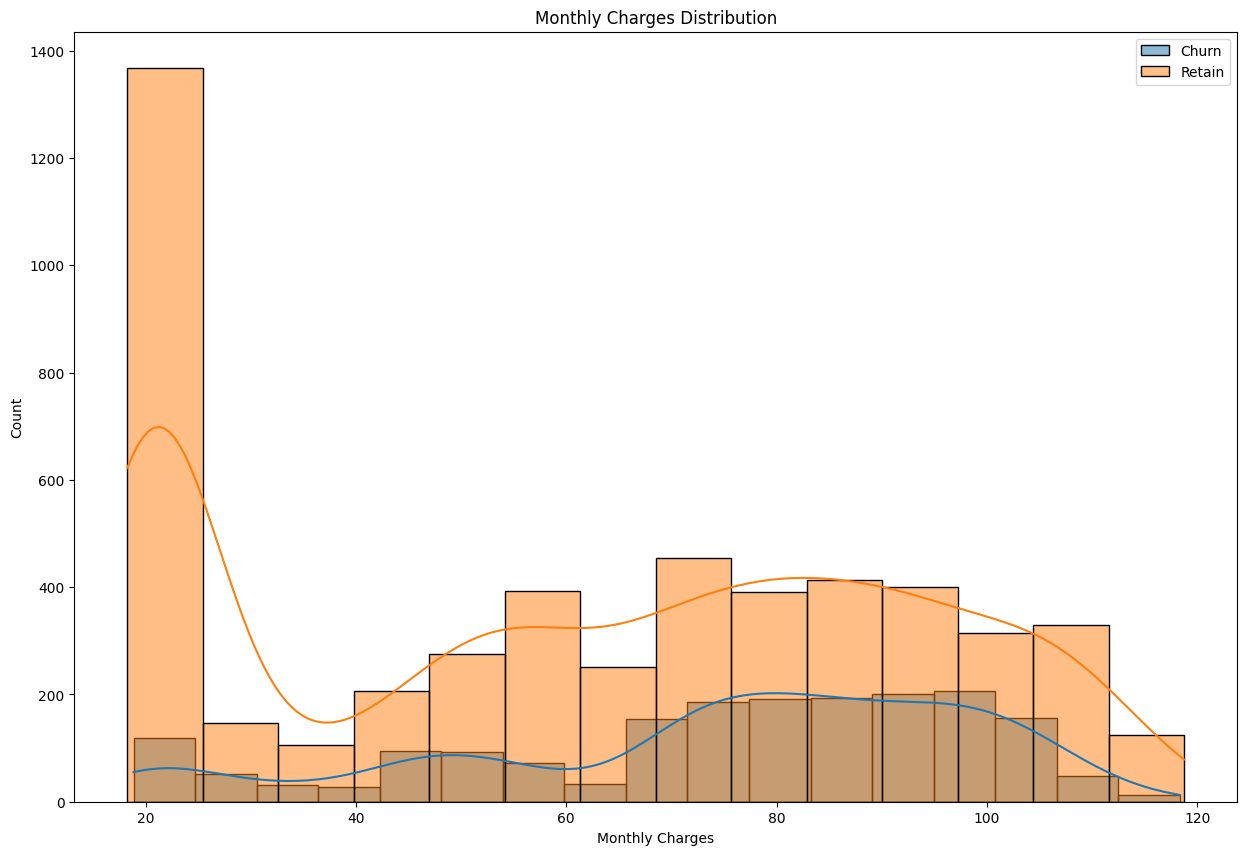

In [42]:
plt.figure(figsize=(15,10))
plt.title('Monthly Charges Distribution')
sns.histplot(df[df['Churn Label'] == 'Yes']['Monthly Charges'], label='Churn', kde = 1)
sns.histplot(df[df['Churn Label'] == 'No']['Monthly Charges'], label='Retain', kde = 1)
plt.legend(loc= 'upper right')
plt.show()

Customer who have month charge over $60 are more likely to churn from the service.

#### 6.4.2 Tenure (Months) of the Customers

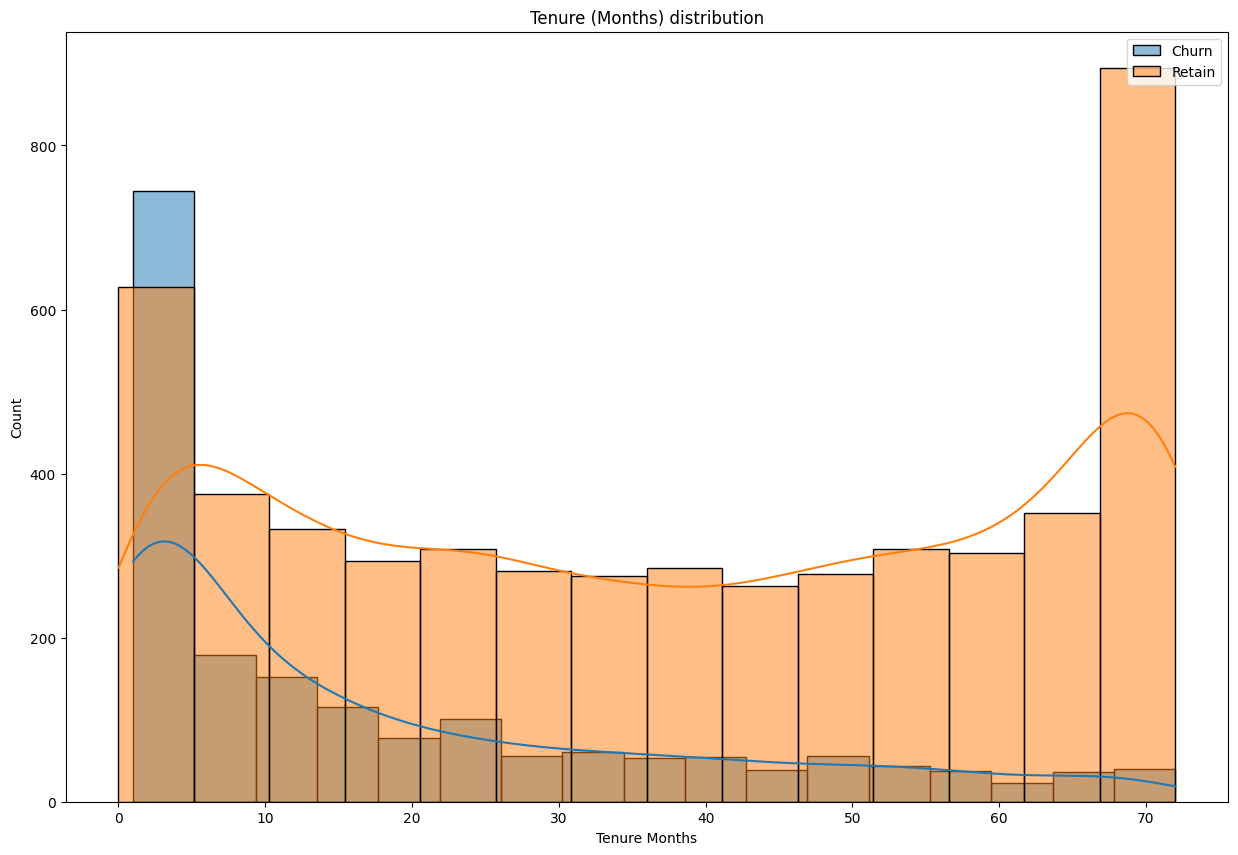

In [43]:
plt.figure(figsize=(15,10))
plt.title('Tenure (Months) distribution')
sns.histplot(df[df['Churn Label'] == 'Yes']['Tenure Months'], label='Churn', kde = 1)
sns.histplot(df[df['Churn Label'] == 'No']['Tenure Months'], label='Retain', kde = 1)
plt.legend(loc= 'upper right')
plt.show()

The probabiliy of chrun decrease as the custommer used the service. 

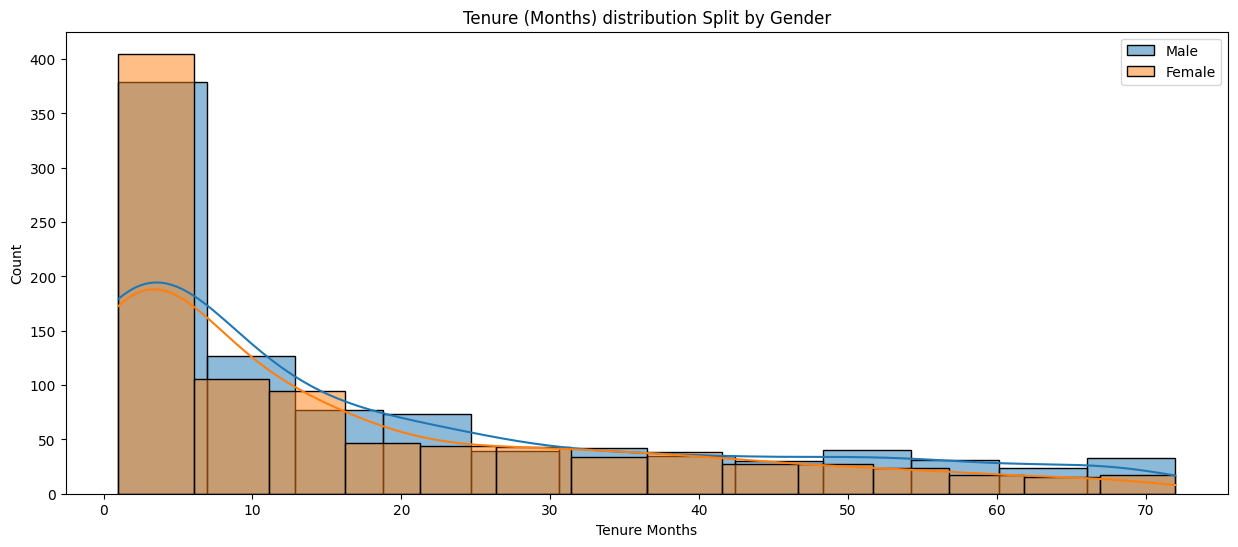

In [44]:

plt.title('Tenure (Months) distribution Split by Gender')

# Create a histogram using histplot
sns.histplot(data=df[(df['Churn Label'] == 'Yes') & (df['Gender'] == 'Male')], x='Tenure Months', label='Male', kde=True)
sns.histplot(data=df[(df['Churn Label'] == 'Yes') & (df['Gender'] == 'Female')], x='Tenure Months', label='Female', kde=True)
plt.legend()
plt.show()

For the subcription period, the male are more likely to churn than the females. Most females are more likely to churn when they have used the service for 10 month.

## 7. Data preprocessing for Model 
- 7.1 - Delete column that have no impact on the model
- 7.2 - Convert categorical features to numerical features
- 7.3 - Split the dataset into train and test set


### 7.1 Delete the columns that are not required for the model

In [45]:
# save the df to another varible
df_telco=df.copy()

In [46]:

df_telco = df_telco.drop(['Country','State','Count','Zip Code','Churn Reason','City','Churn Score','Churn Value','CLTV','CustomerID','Lat Long',
                  'Latitude','Longitude'], axis = 1)

In [47]:
df_telco.head(5)

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label
0,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
2,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
3,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
4,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes


In [48]:
df_telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             7043 non-null   object 
 1   Senior Citizen     7043 non-null   object 
 2   Partner            7043 non-null   object 
 3   Dependents         7043 non-null   object 
 4   Tenure Months      7043 non-null   int64  
 5   Phone Service      7043 non-null   object 
 6   Multiple Lines     7043 non-null   object 
 7   Internet Service   7043 non-null   object 
 8   Online Security    7043 non-null   object 
 9   Online Backup      7043 non-null   object 
 10  Device Protection  7043 non-null   object 
 11  Tech Support       7043 non-null   object 
 12  Streaming TV       7043 non-null   object 
 13  Streaming Movies   7043 non-null   object 
 14  Contract           7043 non-null   object 
 15  Paperless Billing  7043 non-null   object 
 16  Payment Method     7043 

### 7.2 Convert categorial values to numerical values

In [49]:
df_telco['Churn Label'].replace(to_replace='Yes', value=1, inplace=True)
df_telco['Churn Label'].replace(to_replace='No',  value=0, inplace=True)
df_telco.head(3)

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label
0,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1


In [50]:
def encode_data(dataframe_series):
    if dataframe_series.dtype == 'object':
        return LabelEncoder().fit_transform(dataframe_series.astype(str))
    return dataframe_series


data = df_telco.apply(encode_data)
data.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label
0,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,157,1
1,0,0,0,1,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,925,1
2,0,0,0,1,8,1,2,1,0,0,2,0,2,2,0,1,2,99.65,6104,1
3,0,0,1,1,28,1,2,1,0,0,2,2,2,2,0,1,2,104.80,2646,1
4,1,0,0,1,49,1,2,1,0,2,2,0,2,2,0,1,0,103.70,4265,1


Find the correlation between the features and target variable.

In [51]:
fig = px.bar(data.corr()['Churn Label'].sort_values(ascending = False),
             color = 'value')
fig.show()

Check the number of target label in the dataset for perform classification

In [52]:
data.groupby('Churn Label')['Churn Label'].count()

Churn Label
0    5174
1    1869
Name: Churn Label, dtype: int64

The dataset is unbalanced. So, we need to balance the dataset for better model performance. In a unbalanced dataset, the model will be biased towards the majority class. So, we need to balance the dataset.
class imbalance can be solved in various ways:
- Random Under-Sampling
- Random Over-Sampling
- SMOTE (Synthetic Minority Oversampling Technique)

In this case, we use the SMOTE (Synthetic Minority Oversampling Technique) to balance the dataset. SMOTE is a technique for oversampling the minority class by creating synthetic examples. it used KNN to balance the dataset.

In [53]:
over_sample_smote = SMOTE(sampling_strategy = 1)

x = data.drop("Churn Label", axis = 1).values
y = data['Churn Label'].values

In [54]:
print('x shape: ',x.shape)
print('y shape:',y.shape)

x shape:  (7043, 19)
y shape: (7043,)


In [55]:
x,y=over_sample_smote.fit_resample(x,y)

In [56]:
print('after SMOTE x shape: ',x.shape)
print('after SMOTE y shape:',y.shape)

after SMOTE x shape:  (10348, 19)
after SMOTE y shape: (10348,)


In [57]:
# check the number of 1 and 0 
print('y value counts: ',Counter(y)) 

y value counts:  Counter({1: 5174, 0: 5174})


Now, the dataset is balanced. The number of churn and non-churn customers are equal.


### 7.3 Dataset separation using train test split

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state =42, test_size = 0.2)
print('x_train shape: ',x_train.shape)
print('y_train shape:',y_train.shape)
print('x_test shape: ',x_test.shape)
print('y_test shape:',y_test.shape)

x_train shape:  (8278, 19)
y_train shape: (8278,)
x_test shape:  (2070, 19)
y_test shape: (2070,)


## 8. Model Development and Evaluation
- 8.1 - Logistic Regression
- 8.2 - Decision Tree Classifier
- 8.3 - Random Forest Classifier
- 8.4 - XGBoost Classifier


Model training and evaluation functions

In [59]:
def model_training_and_evaluation(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)

    predictions = model.predict(x_test)
    c_matrix = confusion_matrix(y_test, predictions)

    percentages = (c_matrix / np.sum(c_matrix, axis=1)[:, np.newaxis]).round(2) * 100
    labels = [[f"{c_matrix[i, j]} ({percentages[i, j]:.2f}%)" for j in range(c_matrix.shape[1])] for i in range(c_matrix.shape[0])]
    labels = np.asarray(labels)
    

    print("ROC AUC: ", '{:.2%}'.format(roc_auc_score(y_test, predictions)))
    print("Model accuracy: ", '{:.2%}'.format(accuracy_score(y_test, predictions)))
    print('classification_report:\n',classification_report(y_test, predictions))

    sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')

GridSeachCV for hyperparameter tuning

In [60]:
def grid_serach_cv(model, param_grid, x_train, y_train, x_test, y_test):

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(x_train, y_train)
    print("Best Parameters:", grid_search.best_params_)
    print("Best Accuracy Score:", grid_search.best_score_)
    test_accuracy = grid_search.best_estimator_.score(x_test, y_test)
    print("Test Set Accuracy:", test_accuracy)

    # Return the best estimator
    return grid_search.best_estimator_

cross validation for model evaluation

In [61]:
def cross_validation_results(model,x,y,cv):
    cv_scores = cross_val_score(model, x, y, cv=5)
    print("Cross-Validation Scores:", cv_scores)
    print("Mean CV Score:", np.mean(cv_scores))
    print("Standard Deviation of CV Scores:", np.std(cv_scores))

### 8.1 Model Development and Evaluation: Logistic Regression

ROC AUC:  78.31%
Model accuracy:  78.36%
classification_report:
               precision    recall  f1-score   support

           0       0.79      0.76      0.77      1015
           1       0.78      0.81      0.79      1055

    accuracy                           0.78      2070
   macro avg       0.78      0.78      0.78      2070
weighted avg       0.78      0.78      0.78      2070



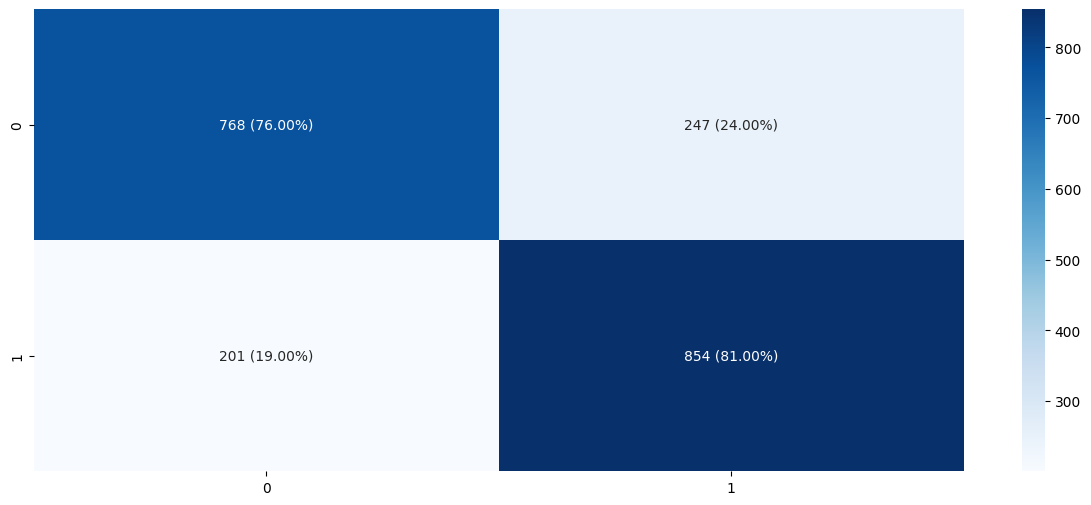

In [62]:

logistic_regression = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear',max_iter=1000))
model_training_and_evaluation(logistic_regression, x_train, y_train, x_test, y_test)

ROC AUC:  81.72%
Model accuracy:  81.69%
classification_report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.82      1015
           1       0.83      0.80      0.82      1055

    accuracy                           0.82      2070
   macro avg       0.82      0.82      0.82      2070
weighted avg       0.82      0.82      0.82      2070



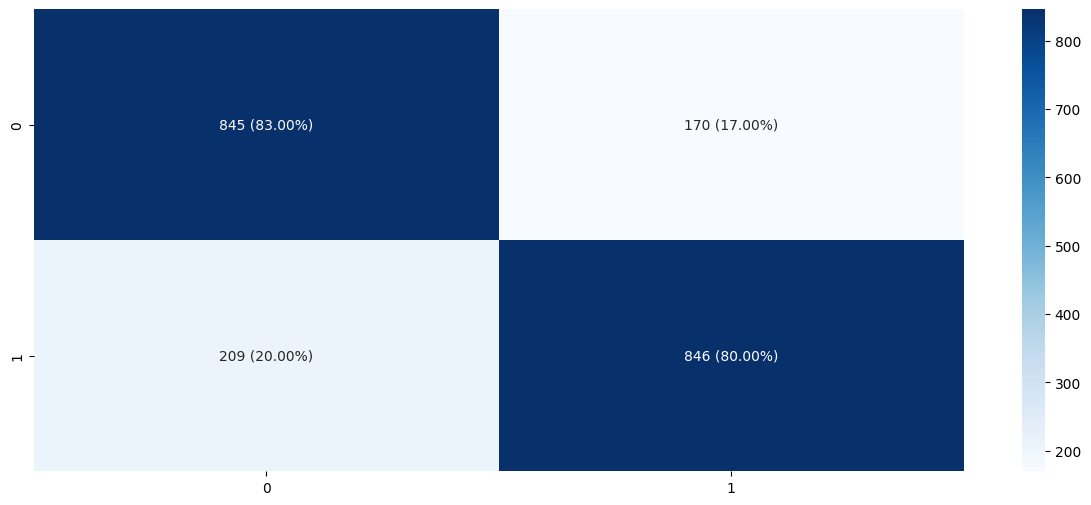

In [63]:
model_training_and_evaluation(DecisionTreeClassifier(), x_train, y_train, x_test, y_test)

In [64]:
## save the model

filename = 'models/logistic_regression_model.sav'
pickle.dump(logistic_regression, open(filename, 'wb'))


### 8.2 Model Development and Evaluation: Decision Tree Classifier

ROC AUC:  80.69%
Model accuracy:  80.68%
classification_report:
               precision    recall  f1-score   support

           0       0.80      0.81      0.80      1015
           1       0.82      0.80      0.81      1055

    accuracy                           0.81      2070
   macro avg       0.81      0.81      0.81      2070
weighted avg       0.81      0.81      0.81      2070



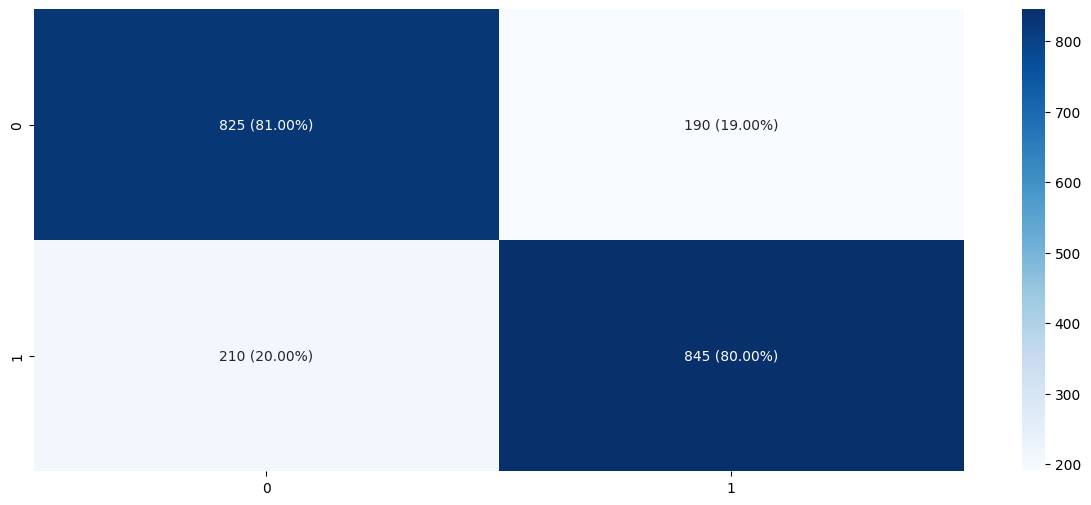

In [65]:

decision_tree = DecisionTreeClassifier(random_state=42)
model_training_and_evaluation(decision_tree, x_train, y_train, x_test, y_test)

### 8.3 Model Development and Evaluation: Random Forest Classifier


ROC AUC:  86.00%
Model accuracy:  85.94%
classification_report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1015
           1       0.89      0.83      0.86      1055

    accuracy                           0.86      2070
   macro avg       0.86      0.86      0.86      2070
weighted avg       0.86      0.86      0.86      2070



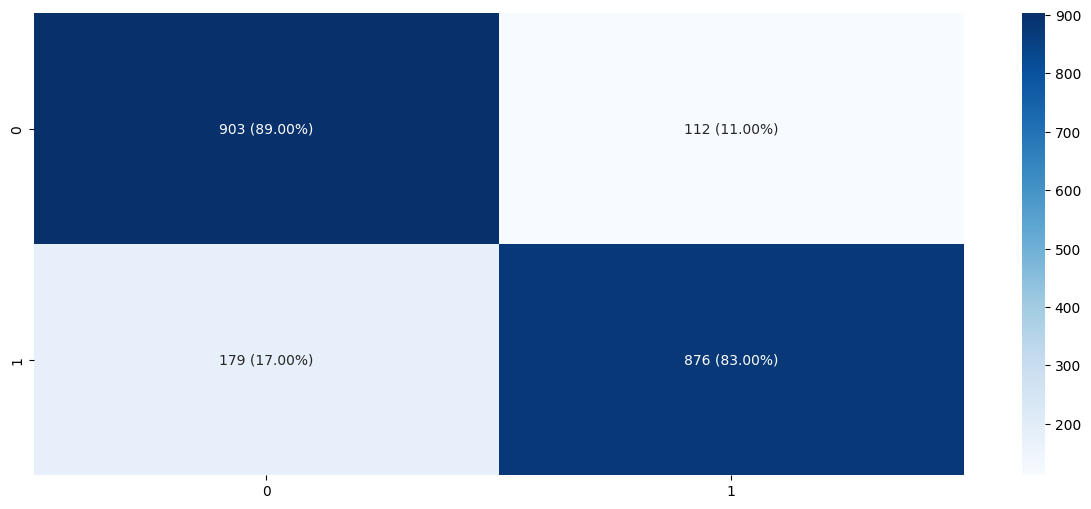

In [66]:

random_forest = RandomForestClassifier(random_state=42)
model_training_and_evaluation(random_forest, x_train, y_train, x_test, y_test)

In [67]:
cross_validation_results(random_forest,x,y,cv=5)

Cross-Validation Scores: [0.67971014 0.74589372 0.91980676 0.93185114 0.93233446]
Mean CV Score: 0.8419192449852085
Standard Deviation of CV Scores: 0.10757491847640809


Hyper parameter tunning using Grid Search CV

In [68]:
random_forest = RandomForestClassifier(random_state=42)
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# grid_serach_cv(random_forest, param_grid, x_train, y_train, x_test, y_test)

ROC AUC:  86.85%
Model accuracy:  86.81%
classification_report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1015
           1       0.89      0.85      0.87      1055

    accuracy                           0.87      2070
   macro avg       0.87      0.87      0.87      2070
weighted avg       0.87      0.87      0.87      2070



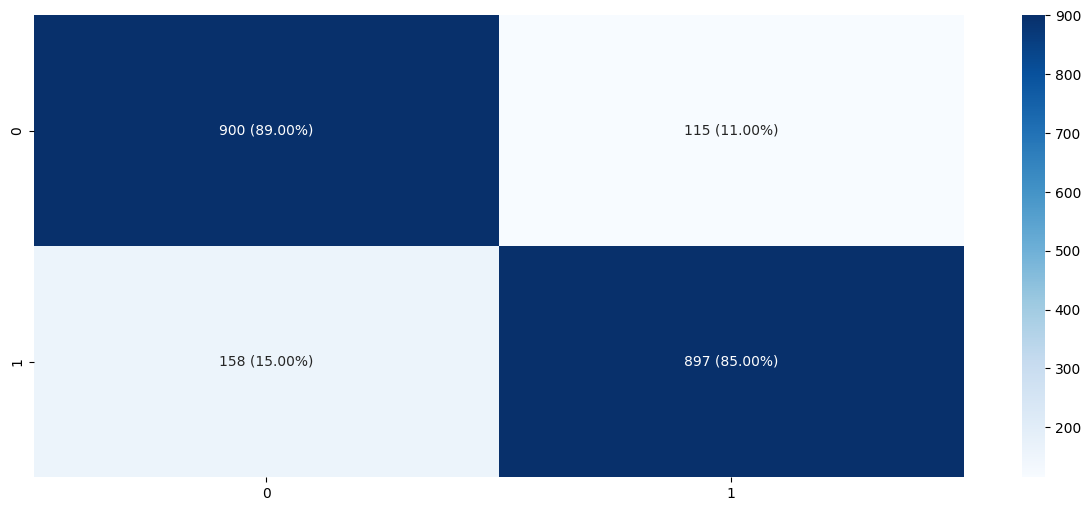

In [69]:
## check the random forest model with best parameters
random_forest_with_finetune = RandomForestClassifier(random_state=42,max_depth=20,min_samples_leaf=1,min_samples_split=10,n_estimators=100)
model_training_and_evaluation(random_forest_with_finetune, x_train, y_train, x_test, y_test)

In [70]:
# save the model
model_name='models/random_forest_model.sav'
pickle.dump(random_forest_with_finetune, open(model_name, 'wb'))


### 8.4 Model Development and Evaluation: Xgboost Classifier

ROC AUC:  86.97%
Model accuracy:  86.96%
classification_report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87      1015
           1       0.88      0.86      0.87      1055

    accuracy                           0.87      2070
   macro avg       0.87      0.87      0.87      2070
weighted avg       0.87      0.87      0.87      2070



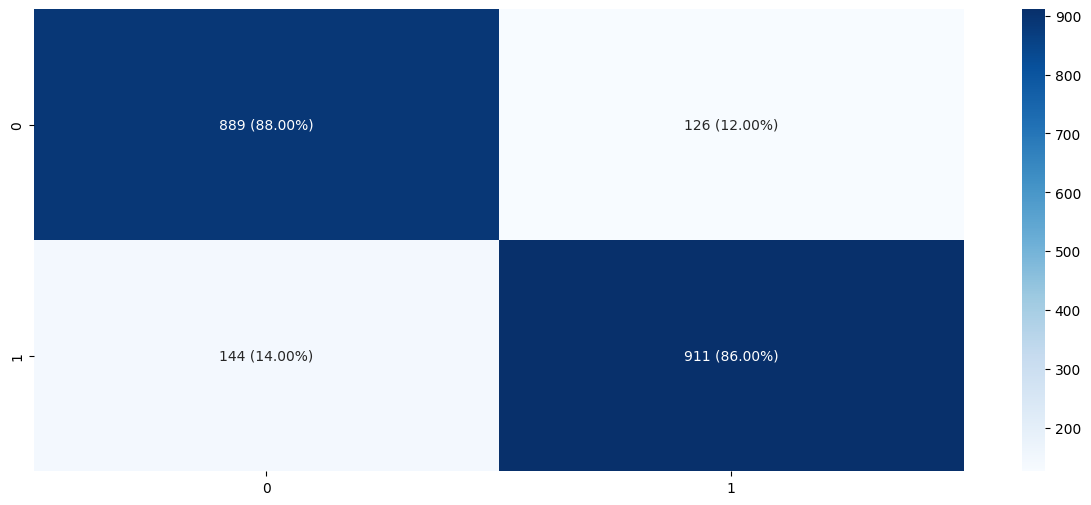

In [71]:
xgb = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)
model_training_and_evaluation(xgb, x_train, y_train, x_test, y_test)


Hyper parameter tunning using Grid Search CV

In [72]:
# Define the XGBoost classifier
xgb_classifier = XGBClassifier(objective='binary:logistic',colsample_bytree=0.5, seed=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'gamma':[0,0.25 ,1.0],
    'reg_lambda':[0,1.0,10],
    'scale_pos_weight':[1,3,5]
}

# grid_serach_cv(xgb_classifier, param_grid, x_train, y_train, x_test, y_test)



ROC AUC:  87.23%
Model accuracy:  87.20%
classification_report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.87      1015
           1       0.89      0.86      0.87      1055

    accuracy                           0.87      2070
   macro avg       0.87      0.87      0.87      2070
weighted avg       0.87      0.87      0.87      2070



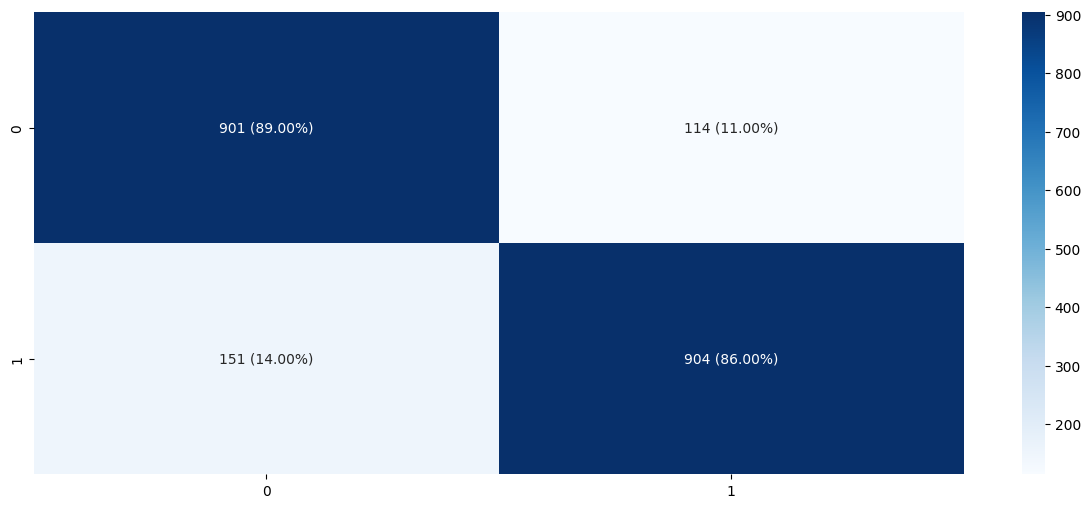

In [73]:
xgb_finetuned = XGBClassifier(learning_rate= 0.3,max_depth = 3,n_estimators = 50)
model_training_and_evaluation(xgb_finetuned, x_train, y_train, x_test, y_test)


In [74]:
## save the model
model_name='models/xgb_model.sav'
pickle.dump(xgb_finetuned, open(model_name, 'wb'))

Using GridSearchCV, the best best hyper parameter are found. performance may increased both random forest classifier and XGBoost classifier.

### Comparative analysis of the models

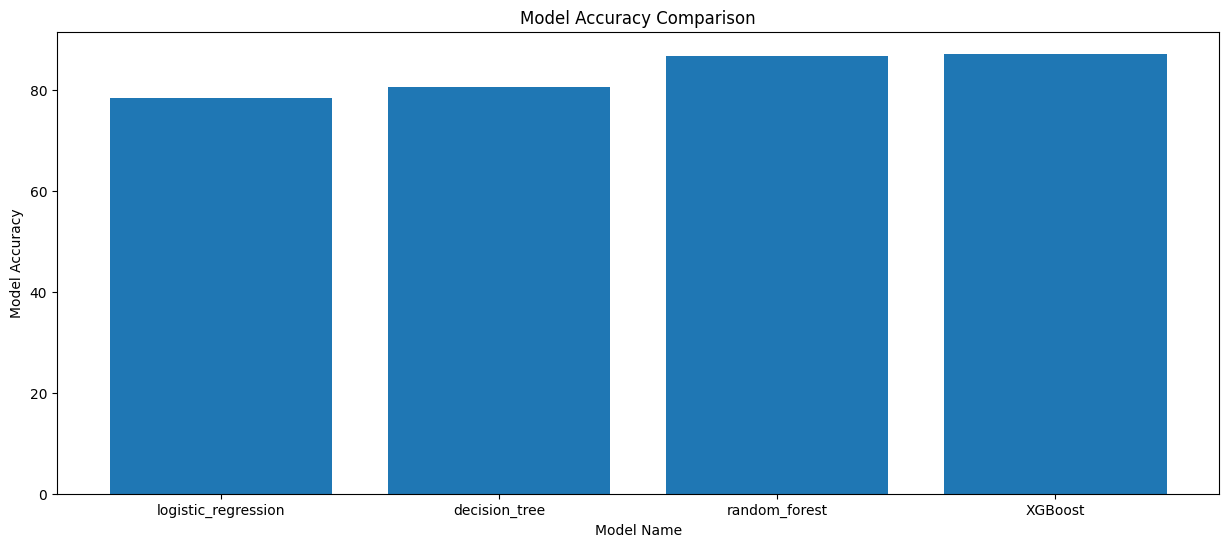

In [76]:
model_name=['logistic_regression','decision_tree','random_forest','XGBoost']
model_accuracy=[78.36,80.68,86.81,87.21]
plt.bar(model_name,model_accuracy)
plt.xlabel('Model Name')
plt.ylabel('Model Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

<Axes: xlabel='Model Name', ylabel='Model Accuracy'>

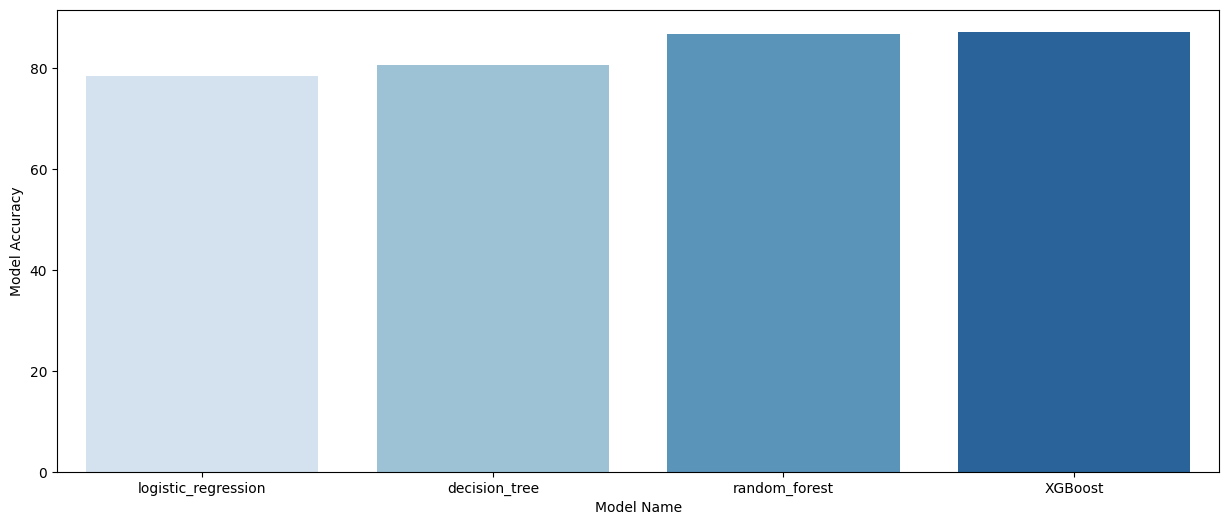

In [81]:

model_name=['logistic_regression','decision_tree','random_forest','XGBoost']
model_accuracy=[78.36,80.68,86.81,87.21]

model_performance_df = pd.DataFrame({'Model Name': model_name, 'Model Accuracy': model_accuracy})

sns.barplot(x='Model Name', y='Model Accuracy', data=model_performance_df, hue='Model Name', dodge=False, palette='Blues', legend=False)

## 9. Conclusion


Efficient data analysis is required to understand the customer churn. The telco company need to focus on the following points to reduce the churn rate.
- The customer churn
- The customer who have fiber optic as internet service without tech support have too much higher churn rate compared to DSL customers
- The customer who have no tech support and online security have higher churn rate than the customer who have tech support and online security.
- Churn rate is too much higher who have payment method is Electronic check. The credit card (automatic) payment method have lower churn rate than others payment method.
- Customer who have month charge over $60 are more likely to churn from the service.
- The probabiliy of chrun decrease as the custommer used the service.


Model performance can be increased by using more data and more features. XGBoost classifier gives the best performance among the other models.